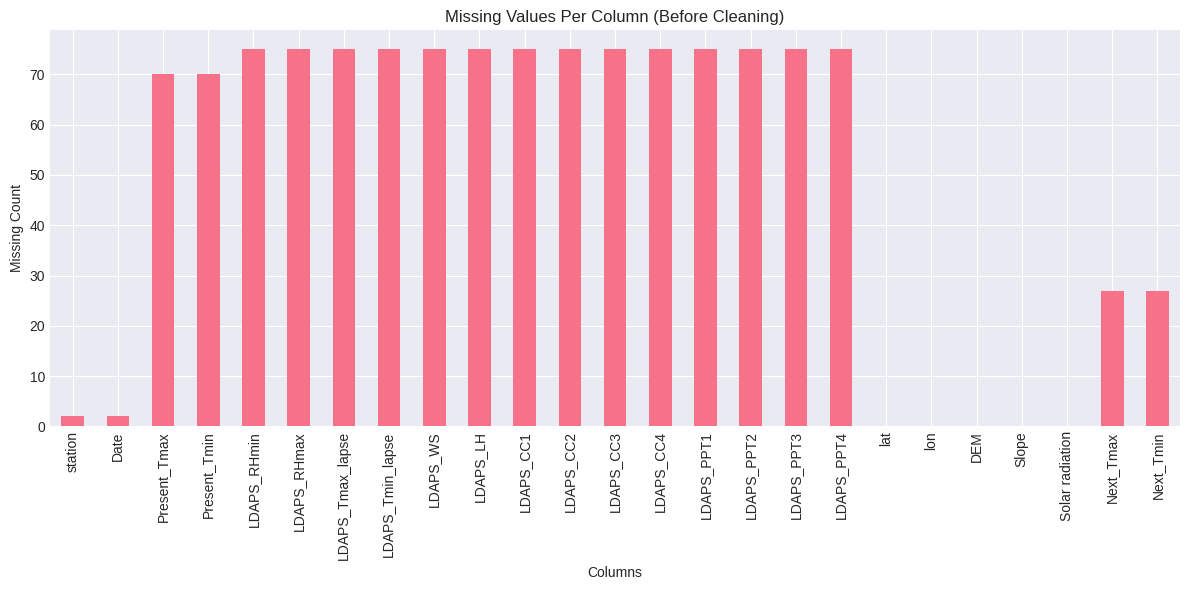

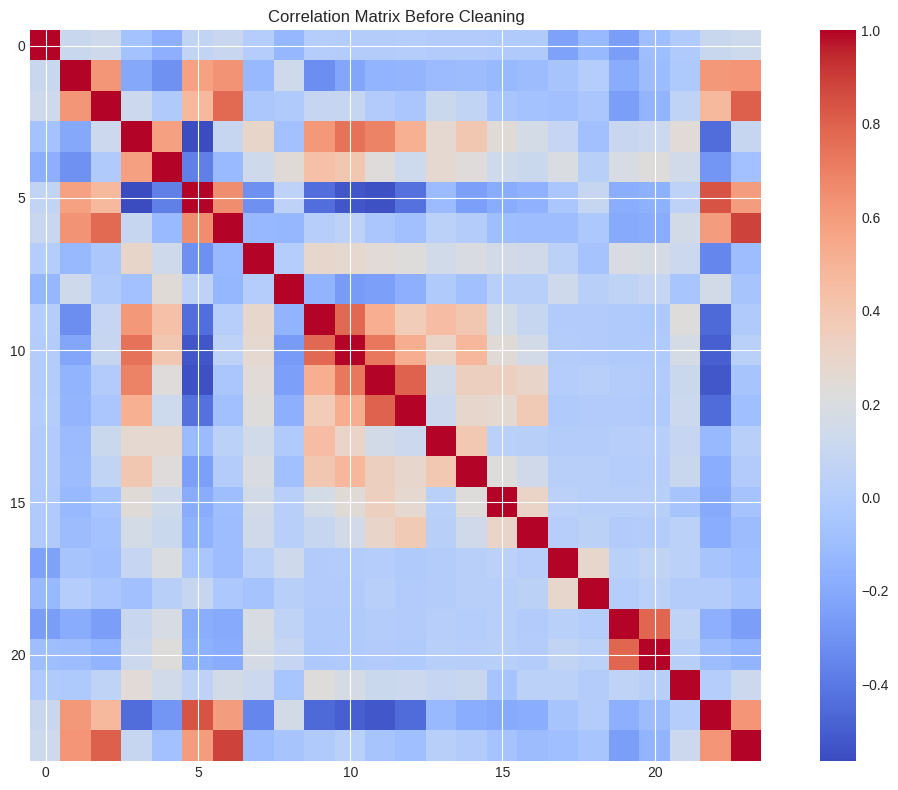

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)


165/165 - 7s - 41ms/step - loss: 0.0241 - mae: 0.1220 - mse: 0.0241 - val_loss: 0.0179 - val_mae: 0.1088 - val_mse: 0.0179 - learning_rate: 5.0000e-04
Epoch 2/200
165/165 - 2s - 14ms/step - loss: 0.0182 - mae: 0.1082 - mse: 0.0182 - val_loss: 0.0157 - val_mae: 0.1033 - val_mse: 0.0157 - learning_rate: 5.0000e-04
Epoch 3/200
165/165 - 2s - 14ms/step - loss: 0.0167 - mae: 0.1047 - mse: 0.0167 - val_loss: 0.0144 - val_mae: 0.0984 - val_mse: 0.0144 - learning_rate: 5.0000e-04
Epoch 4/200
165/165 - 2s - 14ms/step - loss: 0.0152 - mae: 0.0991 - mse: 0.0152 - val_loss: 0.0141 - val_mae: 0.0985 - val_mse: 0.0141 - learning_rate: 5.0000e-04
Epoch 5/200
165/165 - 2s - 14ms/step - loss: 0.0142 - mae: 0.0954 - mse: 0.0142 - val_loss: 0.0126 - val_mae: 0.0917 - val_mse: 0.0126 - learning_rate: 5.0000e-04
Epoch 6/200
165/165 - 2s - 14ms/step - loss: 0.0138 - mae: 0.0941 - mse: 0.0138 - val_loss: 0.0117 - val_mae: 0.0873 - val_mse: 0.0117 - learning_rate: 5.0000e-04
Epoch 7/200
165/165 - 2s - 14ms/st

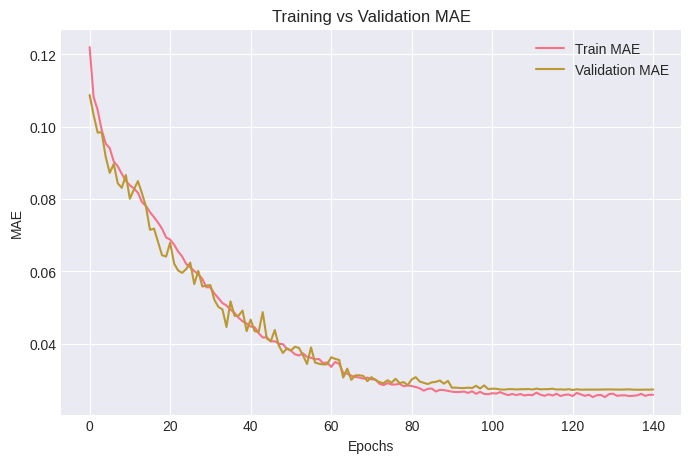

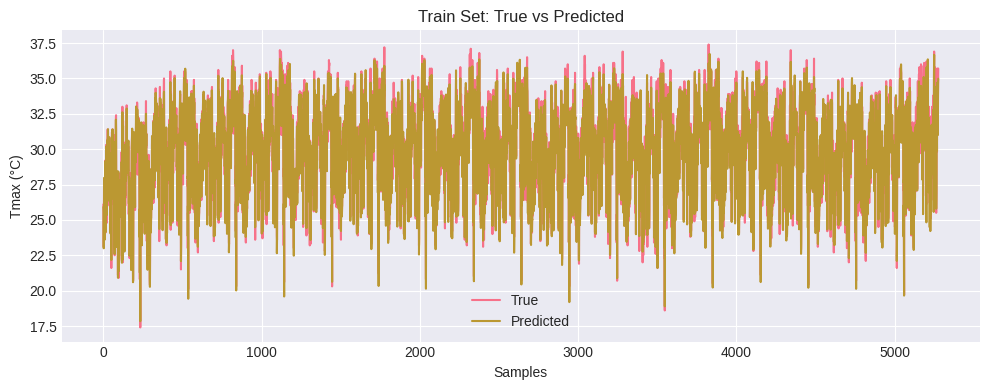

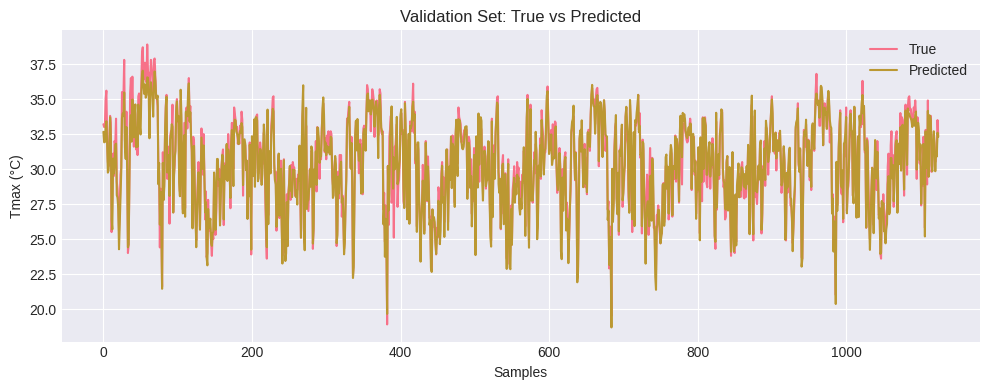

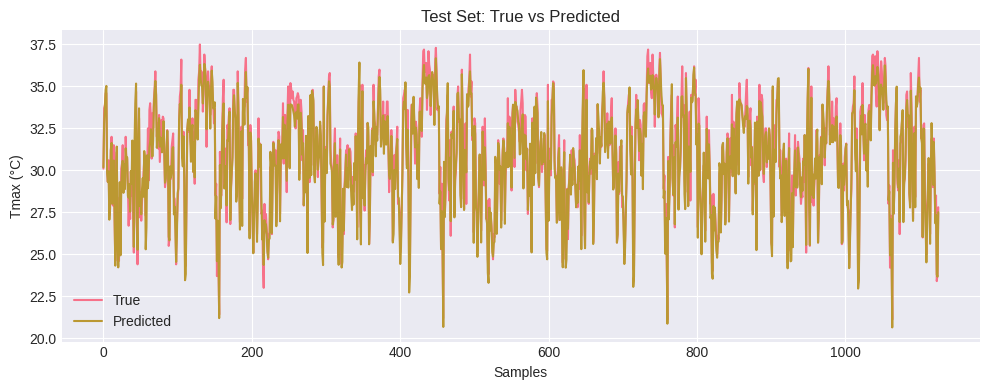

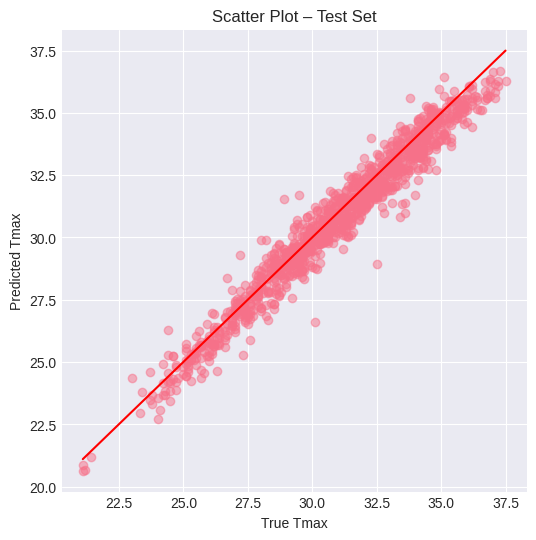

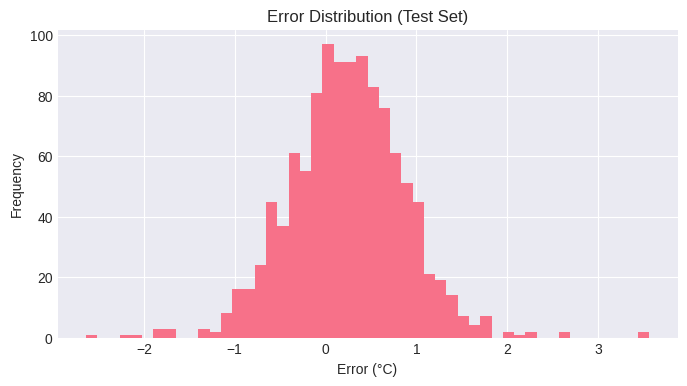

In [22]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

df = pd.read_csv("/kaggle/input/temperature-forecast-project-using-ml/temp.csv")

#plots
plt.figure(figsize=(12, 6))
df.isnull().sum().plot(kind='bar')
plt.title("Missing Values Per Column (Before Cleaning)")
plt.xlabel("Columns")
plt.ylabel("Missing Count")
plt.tight_layout()
plt.show()

df_corr = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
plt.imshow(df_corr.corr(), cmap='coolwarm')
plt.colorbar()
plt.title("Correlation Matrix Before Cleaning")
plt.tight_layout()
plt.show()

# CLEANING & FEATURE ENGINEERING

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(['station', 'Date']).reset_index(drop=True)
df = df.dropna(subset=['Next_Tmax', 'Next_Tmin'])

for col in df.columns:
    if df[col].isnull().sum() > 0 and col not in ['station', 'Date']:
        df[col] = df.groupby('station')[col].transform(lambda x: x.interpolate(method='linear'))

# Feature engineering
df['Month'] = df['Date'].dt.month
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Month_sin'] = np.sin(2*np.pi*df['Month']/12)
df['Month_cos'] = np.cos(2*np.pi*df['Month']/12)
df['DayOfYear_sin'] = np.sin(2*np.pi*df['DayOfYear']/365)
df['DayOfYear_cos'] = np.cos(2*np.pi*df['DayOfYear']/365)

for lag in [1,2,3,7]:
    df[f'Tmax_lag_{lag}'] = df.groupby('station')['Present_Tmax'].shift(lag)
    df[f'Tmin_lag_{lag}'] = df.groupby('station')['Present_Tmin'].shift(lag)

for window in [3,7]:
    df[f'Tmax_rolling_mean_{window}'] = df.groupby('station')['Present_Tmax'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    df[f'Tmin_rolling_mean_{window}'] = df.groupby('station')['Present_Tmin'].transform(lambda x: x.rolling(window, min_periods=1).mean())

df = df.dropna()

# DATASET PREPARATION

feature_cols = [
    'Present_Tmax','Present_Tmin','LDAPS_RHmin','LDAPS_RHmax','LDAPS_Tmax_lapse','LDAPS_Tmin_lapse','LDAPS_WS','LDAPS_LH',
    'LDAPS_CC1','LDAPS_CC2','LDAPS_CC3','LDAPS_CC4','LDAPS_PPT1','LDAPS_PPT2','LDAPS_PPT3','LDAPS_PPT4',
    'lat','lon','DEM','Slope','Solar radiation','Month','DayOfYear','Month_sin','Month_cos','DayOfYear_sin','DayOfYear_cos',
    'Tmax_lag_1','Tmin_lag_1','Tmax_lag_2','Tmin_lag_2','Tmax_lag_3','Tmin_lag_3','Tmax_lag_7','Tmin_lag_7',
    'Tmax_rolling_mean_3','Tmin_rolling_mean_3','Tmax_rolling_mean_7','Tmin_rolling_mean_7'
]

X = df[feature_cols].values
y = df['Next_Tmax'].values

n_samples = len(X)
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test   = X[train_size + val_size:], y[train_size + val_size:]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_val_scaled   = scaler_y.transform(y_val.reshape(-1,1)).flatten()
y_test_scaled  = scaler_y.transform(y_test.reshape(-1,1)).flatten()

#lstm
def create_sequences(X, y, time_steps=7):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

TIME_STEPS = 7
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_val_seq, y_val_seq     = create_sequences(X_val_scaled, y_val_scaled, TIME_STEPS)
X_test_seq, y_test_seq   = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

#lstm model

model = keras.Sequential([
    layers.Input(shape=(TIME_STEPS, X_train_seq.shape[2])),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.15),
    layers.LSTM(64),
    layers.Dropout(0.1),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae', 'mse']
)

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr  = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)


history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

def invert_scale(scaler, data):
    return scaler.inverse_transform(data.reshape(-1,1))

y_pred_train = invert_scale(scaler_y, model.predict(X_train_seq, verbose=0).flatten())
y_pred_val   = invert_scale(scaler_y, model.predict(X_val_seq, verbose=0).flatten())
y_pred_test  = invert_scale(scaler_y, model.predict(X_test_seq, verbose=0).flatten())

y_train_true = invert_scale(scaler_y, y_train_seq)
y_val_true   = invert_scale(scaler_y, y_val_seq)
y_test_true  = invert_scale(scaler_y, y_test_seq)


def calc_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, r2, mape

train_mae, train_rmse, train_r2, train_mape = calc_metrics(y_train_true, y_pred_train)
val_mae, val_rmse, val_r2, val_mape       = calc_metrics(y_val_true, y_pred_val)
test_mae, test_rmse, test_r2, test_mape   = calc_metrics(y_test_true, y_pred_test)


print("TRAIN SET:")
print(f"   MAE: {train_mae:.4f}°C | RMSE: {train_rmse:.4f}°C | R²: {train_r2:.4f} | MAPE: {train_mape:.2f}%")
print("\nVALIDATION SET:")
print(f"   MAE: {val_mae:.4f}°C | RMSE: {val_rmse:.4f}°C | R²: {val_r2:.4f} | MAPE: {val_mape:.2f}%")
print("\nTEST SET:")
print(f"   MAE: {test_mae:.4f}°C | RMSE: {test_rmse:.4f}°C | R²: {test_r2:.4f} | MAPE: {test_mape:.2f}%")


plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title("Training vs Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()



def plot_pred_vs_true(y_true, y_pred, title):
    plt.figure(figsize=(10,4))
    plt.plot(y_true, label="True")
    plt.plot(y_pred, label="Predicted")
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Tmax (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pred_vs_true(y_train_true, y_pred_train, "Train Set: True vs Predicted")
plot_pred_vs_true(y_val_true, y_pred_val, "Validation Set: True vs Predicted")
plot_pred_vs_true(y_test_true, y_pred_test, "Test Set: True vs Predicted")


plt.figure(figsize=(6,6))
plt.scatter(y_test_true, y_pred_test, alpha=0.5)
plt.xlabel("True Tmax")
plt.ylabel("Predicted Tmax")
plt.title("Scatter Plot – Test Set")
plt.plot([min(y_test_true), max(y_test_true)], [min(y_test_true), max(y_test_true)], 'r')
plt.show()


errors = y_test_true.flatten() - y_pred_test.flatten()

plt.figure(figsize=(8,4))
plt.hist(errors, bins=50)
plt.title("Error Distribution (Test Set)")
plt.xlabel("Error (°C)")
plt.ylabel("Frequency")
plt.show()


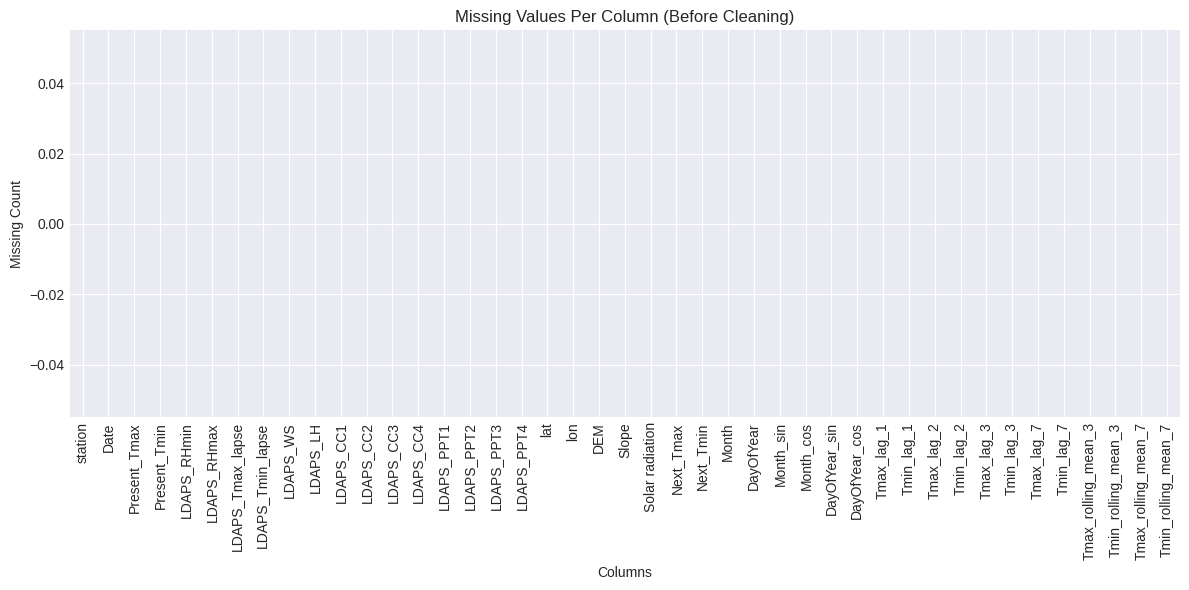

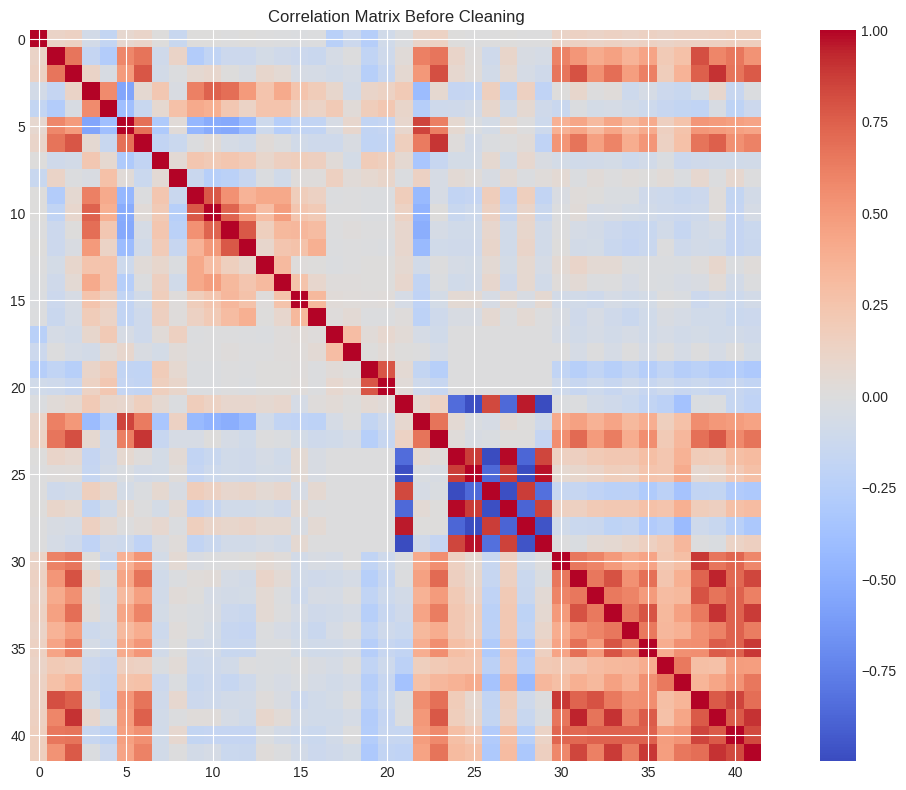

TRAIN SET:
  MAE: 0.3704°C | RMSE: 0.5054°C | R²: 0.9746 | MAPE: 1.26%

VALIDATION SET:
  MAE: 0.7212°C | RMSE: 0.9513°C | R²: 0.9122 | MAPE: 2.35%

TEST SET:
  MAE: 0.6538°C | RMSE: 0.8259°C | R²: 0.9304 | MAPE: 2.10%


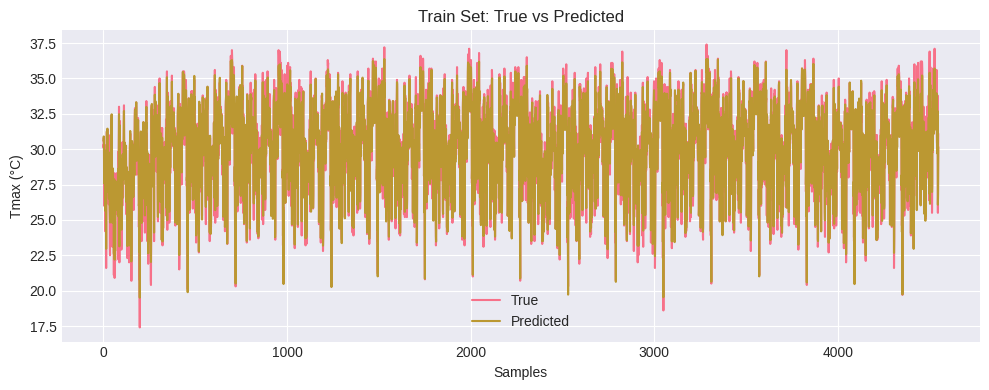

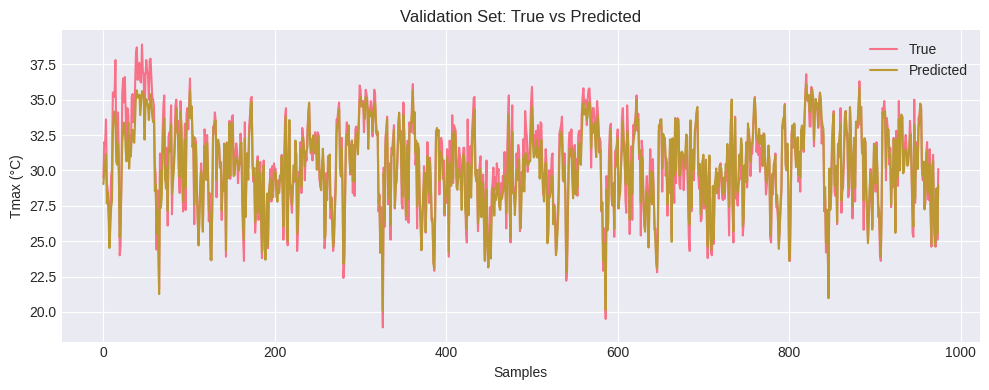

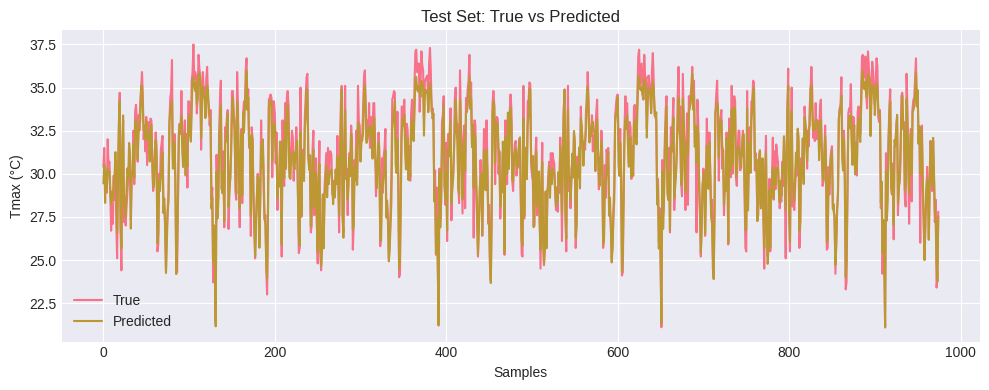

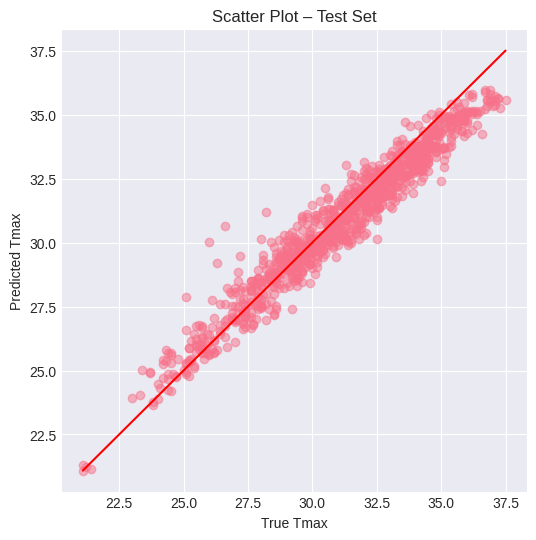

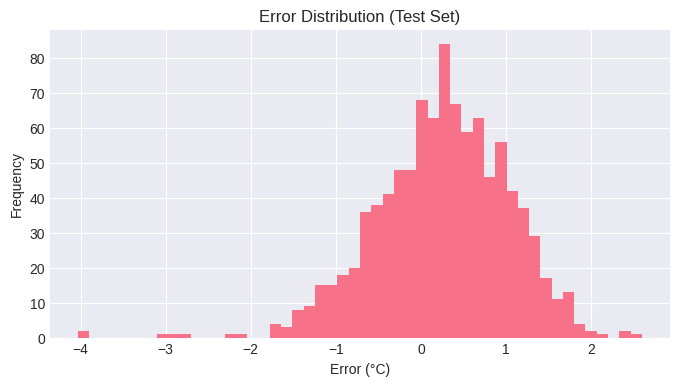

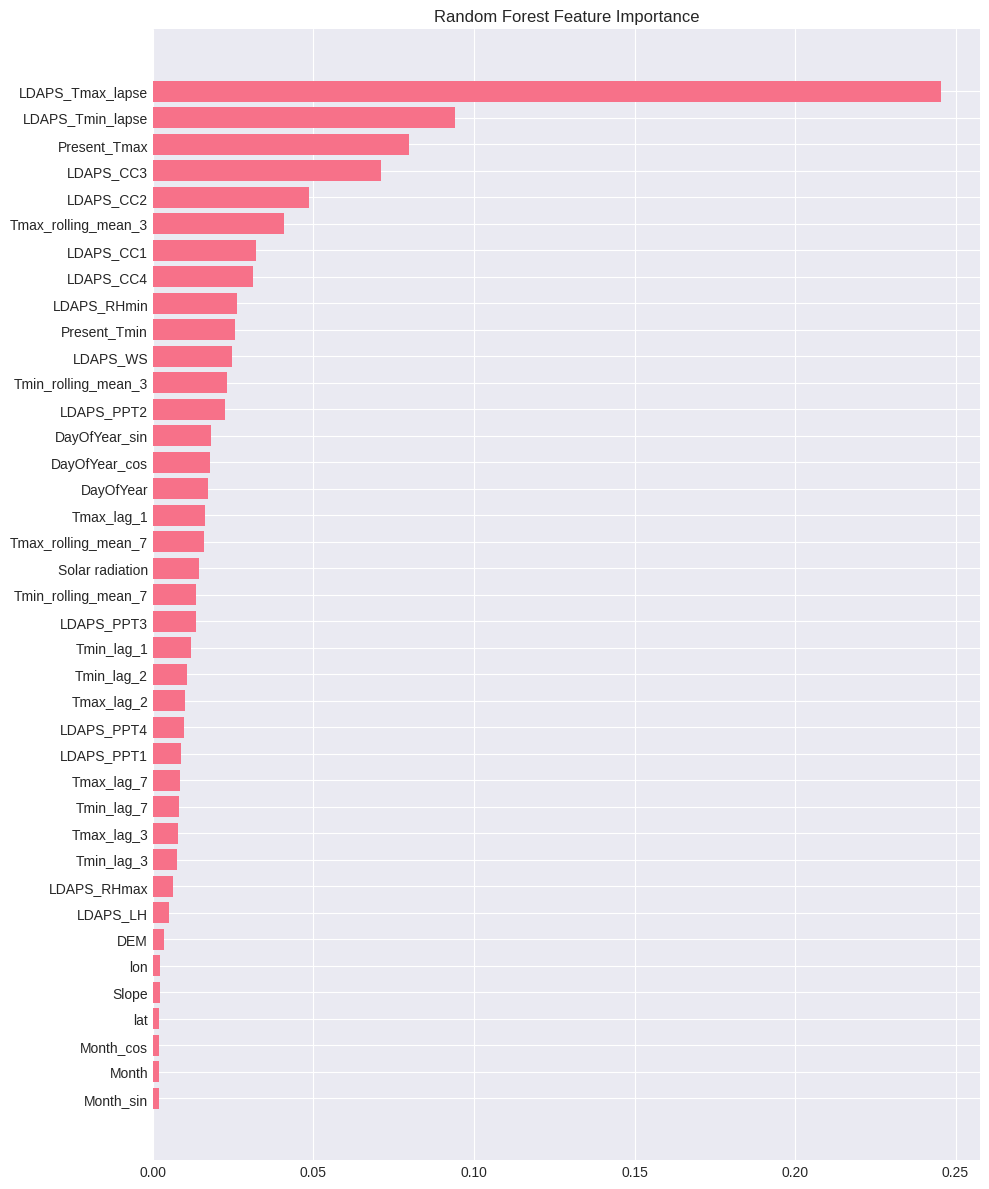

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df.isnull().sum().plot(kind='bar')
plt.title("Missing Values Per Column (Before Cleaning)")
plt.xlabel("Columns")
plt.ylabel("Missing Count")
plt.tight_layout()
plt.show()

df_corr = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
plt.imshow(df_corr.corr(), cmap="coolwarm")
plt.colorbar()
plt.title("Correlation Matrix Before Cleaning")
plt.tight_layout()
plt.show()

#data preparation
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(['station', 'Date']).reset_index(drop=True)
df = df.dropna(subset=['Next_Tmax', 'Next_Tmin'])

for col in df.columns:
    if df[col].isnull().sum() > 0 and col not in ['station', 'Date']:
        df[col] = df.groupby('station')[col].transform(lambda x: x.interpolate(method='linear'))

# Feature engineering
df['Month'] = df['Date'].dt.month
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Month_sin'] = np.sin(2*np.pi*df['Month']/12)
df['Month_cos'] = np.cos(2*np.pi*df['Month']/12)
df['DayOfYear_sin'] = np.sin(2*np.pi*df['DayOfYear']/365)
df['DayOfYear_cos'] = np.cos(2*np.pi*df['DayOfYear']/365)

for lag in [1,2,3,7]:
    df[f'Tmax_lag_{lag}'] = df.groupby('station')['Present_Tmax'].shift(lag)
    df[f'Tmin_lag_{lag}'] = df.groupby('station')['Present_Tmin'].shift(lag)

for window in [3,7]:
    df[f'Tmax_rolling_mean_{window}'] = df.groupby('station')['Present_Tmax'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    df[f'Tmin_rolling_mean_{window}'] = df.groupby('station')['Present_Tmin'].transform(lambda x: x.rolling(window, min_periods=1).mean())

df = df.dropna()

X = df[feature_cols].values
y = df["Next_Tmax"].values


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, shuffle=False
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


rf = RandomForestRegressor(
    n_estimators=900,       
    max_depth=28,            
    min_samples_split=6,     
    min_samples_leaf=3,      
    max_features='sqrt',     
    bootstrap=True,          
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)

y_pred_train = rf.predict(X_train_scaled)
y_pred_val   = rf.predict(X_val_scaled)
y_pred_test  = rf.predict(X_test_scaled)


def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, r2, mape

train_mae, train_rmse, train_r2, train_mape = metrics(y_train, y_pred_train)
val_mae, val_rmse, val_r2, val_mape         = metrics(y_val, y_pred_val)
test_mae, test_rmse, test_r2, test_mape     = metrics(y_test, y_pred_test)

print("TRAIN SET:")
print(f"  MAE: {train_mae:.4f}°C | RMSE: {train_rmse:.4f}°C | R²: {train_r2:.4f} | MAPE: {train_mape:.2f}%")

print("\nVALIDATION SET:")
print(f"  MAE: {val_mae:.4f}°C | RMSE: {val_rmse:.4f}°C | R²: {val_r2:.4f} | MAPE: {val_mape:.2f}%")

print("\nTEST SET:")
print(f"  MAE: {test_mae:.4f}°C | RMSE: {test_rmse:.4f}°C | R²: {test_r2:.4f} | MAPE: {test_mape:.2f}%")


def plot_pred_vs_true(y_true, y_pred, title):
    plt.figure(figsize=(10,4))
    plt.plot(y_true, label="True")
    plt.plot(y_pred, label="Predicted")
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Tmax (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pred_vs_true(y_train, y_pred_train, "Train Set: True vs Predicted")
plot_pred_vs_true(y_val,   y_pred_val,   "Validation Set: True vs Predicted")
plot_pred_vs_true(y_test,  y_pred_test,  "Test Set: True vs Predicted")



plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.xlabel("True Tmax")
plt.ylabel("Predicted Tmax")
plt.title("Scatter Plot – Test Set")

min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r')
plt.show()


errors = y_test - y_pred_test

plt.figure(figsize=(8,4))
plt.hist(errors, bins=50)
plt.title("Error Distribution (Test Set)")
plt.xlabel("Error (°C)")
plt.ylabel("Frequency")
plt.show()

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,12))
plt.barh(range(len(feature_cols)), importances[indices])
plt.yticks(range(len(feature_cols)), np.array(feature_cols)[indices])
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


 Fichiers disponibles :
/kaggle/input/temperature-forecast-project-using-ml/temp.csv
Les 5 premières lignes de données :
   station        Date  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  \
0      1.0  30-06-2013          28.7          21.4    58.255688    91.116364   
1      2.0  30-06-2013          31.9          21.6    52.263397    90.604721   
2      3.0  30-06-2013          31.6          23.3    48.690479    83.973587   
3      4.0  30-06-2013          32.0          23.4    58.239788    96.483688   
4      5.0  30-06-2013          31.4          21.9    56.174095    90.155128   

   LDAPS_Tmax_lapse  LDAPS_Tmin_lapse  LDAPS_WS    LDAPS_LH  ...  LDAPS_PPT2  \
0         28.074101         23.006936  6.818887   69.451805  ...         0.0   
1         29.850689         24.035009  5.691890   51.937448  ...         0.0   
2         30.091292         24.565633  6.138224   20.573050  ...         0.0   
3         29.704629         23.326177  5.650050   65.727144  ...         0.0  

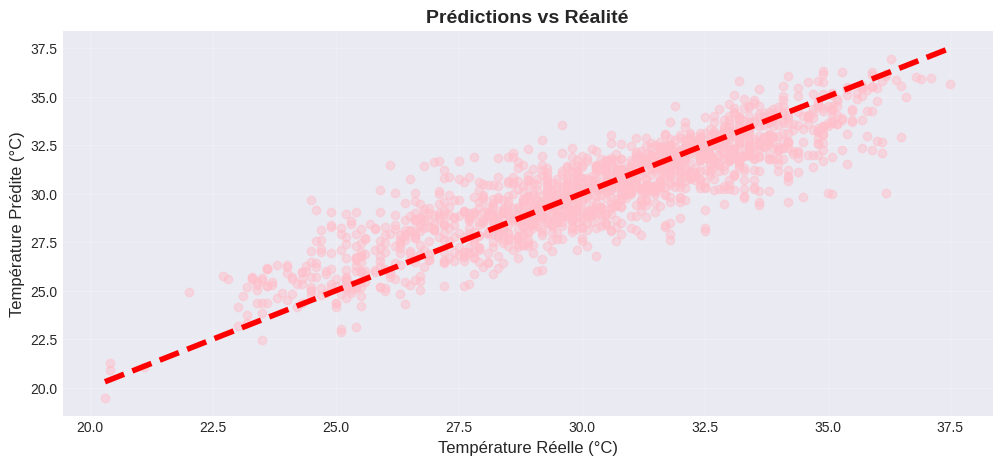

In [7]:
import os
print(" Fichiers disponibles :")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np              
import pandas as pd            
import matplotlib.pyplot as plt 
import seaborn as sns          
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression     
from sklearn.preprocessing import StandardScaler     
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
df = pd.read_csv('/kaggle/input/temperature-forecast-project-using-ml/temp.csv')

print("Les 5 premières lignes de données :")
print(df.head())
print(f"\n\n Taille du dataset : {df.shape[0]} lignes et {df.shape[1]} colonnes")

print("\n\n Colonnes disponibles :")
print(df.columns.tolist())



df_numeric = df.select_dtypes(include=['number'])

correlations = df_numeric.corr()['Next_Tmax'].sort_values(ascending=False)
print(correlations)

seuil_correlation = 0.3
variables_correl = correlations[abs(correlations) > seuil_correlation].index.tolist()

print("\n\n Variable avec une forte relation : \n", variables_correl)


# Preparer les donnees
colonnes_a_retirer = ['Next_Tmax', 'Next_Tmin', 'LDAPS_Tmin_lapse']

for col in colonnes_a_retirer:
    if col in variables_correl:
        variables_correl.remove(col)

print("\n\n Colonnes de prediction :", variables_correl)

Used_Colonne = variables_correl + ['Next_Tmax']


data_simple = df[Used_Colonne].dropna()

print(f" Données chargées avant le traitement: {df.shape[0]} lignes")
y = data_simple['Next_Tmax']
X = data_simple.drop(columns=['Next_Tmax'])


print(f"\n Nombre d'exemples utilise : {X.shape[0]}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    
)

print(" Données d'entraînement :")
print(f"   X_train : {X_train.shape[0]} lignes")

print("\n Données de test :")
print(f"   X_test : {X_test.shape[0]} lignes")



#  Normaliser les donnees
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalisation Done")

# Créer le modèle de régression linéaire
modele = LinearRegression()

modele.fit(X_train_scaled, y_train)
print(" training done")
y_pred = modele.predict(X_test_scaled)
print("\n Prediction done")

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
mae = mean_absolute_error(y_test, y_pred)  
r2 = r2_score(y_test, y_pred) 

print("\n RESULTATS DU MODELE ")
print(f" R² Score :{r2:.4f}")
print(f"\n RMSE (Root Mean Squared Error) : {rmse:.2f}°C")
print(f"\n MAE (Mean Absolute Error) : {mae:.2f}°C")
print(f"\n MSE (Mean Squared Error) : {mse:.2f}")

plt.figure(figsize=(12, 5))

plt.scatter(y_test, y_pred, alpha=0.5, color='pink')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
plt.xlabel('Température Réelle (°C)', fontsize=12)
plt.ylabel('Température Prédite (°C)', fontsize=12)
plt.title('Prédictions vs Réalité', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.2)
plt.show()